In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cp /content/drive/MyDrive/9517_gp/Sequences.zip .
! unzip -qo ./Sequences.zip -d ./Sequences

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, random_split

import torchvision
import torchvision.transforms.functional as VF

from tqdm import tqdm

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

Tesla P100-PCIE-16GB


In [15]:
path_root = '.'

In [13]:
# def frame_trackbar_onChange(pos, prop):
#     # print(pos)
#     prop['i'] = pos
#     cv2.imshow(prop['window_name'], prop['imageSet'][pos])
#     return
    
# def window_onMouse(event, x, y, flag, prop):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         prop['pause'] = not prop['pause']
#     elif event == cv2.EVENT_MOUSEWHEEL and prop['pause']:
#         if flag > 0:
#             prop['i'] = max(prop['i'] - 1, 0)
#         else:
#             prop['i'] = min(prop['i'] + 1, len(prop['imageSet']) - 1)
#         cv2.setTrackbarPos('frame', prop['window_name'], prop['i'])

# def show_images_in_animation_cv(imageSet, interval=100, repeat_delay=1000, window_name='Animation'):
#     visable = True
#     prop = {'window_name': window_name, 'i': 0, 'imageSet': imageSet, 'pause': False}
#     cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)
#     cv2.createTrackbar('frame', window_name, 0, len(imageSet) - 1, lambda v: frame_trackbar_onChange(v, prop))
#     cv2.setMouseCallback(window_name, window_onMouse, prop)
#     while visable:
#         while prop['pause'] and cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE):
#             cv2.waitKey(1)
            
#         cv2.setTrackbarPos('frame', prop['window_name'], prop['i'])
        
#         key = cv2.waitKey(interval)
#         visable = cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE)
#         if not visable:
#             break
#         prop['i'] += 1
        
#         if prop['i'] == len(imageSet):
#             prop['i'] = 0
#             cv2.waitKey(repeat_delay)
#             visable = cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE)

# def compare_images_in_animation_cv(imageSets, interval=100, repeat_delay=1000, window_name='Animation', window_width=1200):
#     visable = True
#     imageSets_in_BGR = []
#     for s in imageSets:
#         if len(s[0].shape) == 2:
#             new_set = []
#             for img in s:
#                 new_set.append(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))
#             imageSets_in_BGR.append(new_set)
#         else:
#             imageSets_in_BGR.append(s)

#     imageSets_in_BGR = np.array(imageSets_in_BGR).transpose(1,0,2,3,4)
#     height, width, _ = np.hstack(imageSets_in_BGR[0]).shape

#     imageSet = []
#     for imgs in imageSets_in_BGR:
#         imageSet.append(np.hstack(imgs))
        
#     prop = {'window_name': window_name, 'i': 0, 'imageSet': imageSet, 'pause': False}
#     cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
#     cv2.resizeWindow(window_name, window_width, int(window_width * height / width))
#     cv2.createTrackbar('frame', window_name, 0, len(imageSet) - 1, lambda v: frame_trackbar_onChange(v, prop))
#     cv2.setMouseCallback(window_name, window_onMouse, prop)
#     while visable:
#         while prop['pause'] and cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE):
#             cv2.waitKey(1)
#         cv2.setTrackbarPos('frame', window_name, prop['i'])
#         key = cv2.waitKey(interval)
#         visable = cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE)
#         if not visable:
#             break
#         prop['i'] += 1
#         if prop['i'] == len(imageSet):
#             prop['i'] = 0
#             cv2.waitKey(repeat_delay)
#             visable = cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE)

In [13]:
def global_grey_stretch(imageSet, convert_color=True):
    global_max = np.max(imageSet)
    global_min = np.min(imageSet)
    folder = []
    for i in imageSet:
        if convert_color:
            i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        folder.append(np.uint8((i - global_min) / (global_max - global_min) * 255))
    return folder

In [11]:
def open_files(num, flags=cv2.IMREAD_COLOR):
    image_list = []
    path = path_root + '/Sequences/'+num
    file_list = sorted([files for roots, dirs, files in os.walk(path)][0])
    for fname in file_list:
        src = path + '/' + fname
        img = cv2.imread(src, flags)
        image_list.append(img)
    return image_list

In [12]:
def resize(img_folder):
    folder = []
    for img in img_folder:
        folder.append(cv2.resize(img, (0, 0), fx=.5, fy=.5))
    return folder

In [17]:
def clear_background(img_folder):
    folder = []
    for img in img_folder:
        count = np.bincount(np.reshape(img, -1))
        threshold_value = np.argmax(count)
        _, img = cv2.threshold(img, threshold_value, 255, cv2.THRESH_TOZERO)
        folder.append(img)
    return folder

In [27]:
def get_true_gt(img_folder, img_folder_GT):
    
    folder = []
    for img, img_gt in zip(img_folder, img_folder_GT):
        _, img_thres = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        sure_bg = cv2.dilate(img_thres, np.ones((3,3)), iterations=3)
        img_gt = cv2.bitwise_and(img_gt, sure_bg)

        sure_fg = np.uint8(img_gt)
        unknown = cv2.subtract(sure_bg,sure_fg)

        _, markers = cv2.connectedComponents(sure_fg)
        markers = markers+1
        markers[unknown==255] = 0

        img = np.uint8(img_thres)
        img = cv2.dilate(img, np.ones((3,3)), iterations=2)
        img = cv2.erode(img, np.ones((3,3)), iterations=2)

        markers = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers)
        img[markers == -1] = 0

        img = cv2.erode(img, np.ones((3,3)), iterations=1)
        contour = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,5,3)
        contour = np.where(contour>0, 0, 255).astype(np.uint8)
        folder.append(contour)
    return folder

In [28]:
# img = folder_01[0]
# img_gt = folder_01_TRA_threshold[0]


# plt.figure(dpi=200)
# plt.imshow(img, cmap='gray')

In [29]:
# temp end

In [30]:
def threshold_GT(folder_GT, t=0):
    out = []
    for img in folder_GT:
        out.append(np.where(img > t, 1, 0).astype(np.uint8))
        
    return out

In [31]:
folder_01_original = open_files('01')
folder_01_TRA = open_files('01_GT/TRA', cv2.IMREAD_UNCHANGED)

folder_02_original = open_files('02')
folder_02_TRA = open_files('02_GT/TRA', cv2.IMREAD_UNCHANGED)

In [55]:
folder_01 = global_grey_stretch(folder_01_original)
# folder_01 = clear_background(folder_01)
folder_01_TRA_threshold = threshold_GT(folder_01_TRA)
folder_01_TRA_threshold = get_true_gt(clear_background(folder_01), folder_01_TRA_threshold)
folder_01_TRA_threshold = threshold_GT(folder_01_TRA_threshold)

folder_02 = global_grey_stretch(folder_02_original)
# folder_02 = clear_background(folder_02)
folder_02_TRA_threshold = threshold_GT(folder_02_TRA)
folder_02_TRA_threshold = get_true_gt(clear_background(folder_02), folder_02_TRA_threshold)
folder_02_TRA_threshold = threshold_GT(folder_02_TRA_threshold)

In [56]:
folder_01_TRA_threshold[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [57]:
# compare_images_in_animation_cv([folder_01, folder_01_TRA_threshold], window_width=1800)

In [58]:
folder_01 = resize(folder_01)
folder_01_TRA_threshold = resize(folder_01_TRA_threshold)

folder_02 = resize(folder_02)
folder_02_TRA_threshold = resize(folder_02_TRA_threshold)

In [59]:
folder_01[0].shape

(350, 550)

In [60]:
def image_split(folder, folder_GT, step=64, size=128):
    out_img = []
    out_GT = []
    for img, img_GT in zip(folder, folder_GT):
        h, w = img.shape
        for y in range((h - size) // step):
            for x in range((w - size) // step):
                sub_GT = img_GT[y*step:y*step+size, x*step:x*step+size]
                if sub_GT.max() > 0:
                    sub = img[y*step:y*step+size, x*step:x*step+size]
                    out_img.append(sub)
                    out_GT.append(sub_GT)
            sub_GT = img_GT[y*step:y*step+size, -size-1:-1]
            if sub_GT.max() > 0:
                sub = img[y*step:y*step+size, -size-1:-1]
                out_img.append(sub)
                out_GT.append(sub_GT)

        for x in range((w - size) // step):
            sub_GT = img_GT[-size-1:-1, x*step:x*step+size]
            if sub_GT.max() > 0:
                sub = img[-size-1:-1, x*step:x*step+size]
                out_img.append(sub)
                out_GT.append(sub_GT)
        sub_GT = img_GT[-size-1:-1, -size-1:-1]
        if sub_GT.max() > 0:
            sub = img[-size-1:-1, -size-1:-1]
            out_img.append(sub)
            out_GT.append(sub_GT)
        

    return [out_img, out_GT]

In [61]:
folder_01_splited, folder_01_GT_splited = image_split(folder_01, folder_01_TRA_threshold)
folder_02_splited, folder_02_GT_splited = image_split(folder_02, folder_02_TRA_threshold)

In [62]:
imageS, labelS = [], []
for img in np.concatenate((np.array(folder_01_splited), np.array(folder_02_splited)), axis=0):
    imageS.append([img])
    
for img in np.concatenate((np.array(folder_01_GT_splited), np.array(folder_02_GT_splited)), axis=0):
    labelS.append([img])
dataset = np.concatenate(([imageS], [labelS])).transpose(1,0,2,3,4)

In [63]:
dataset[0][1][0]

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

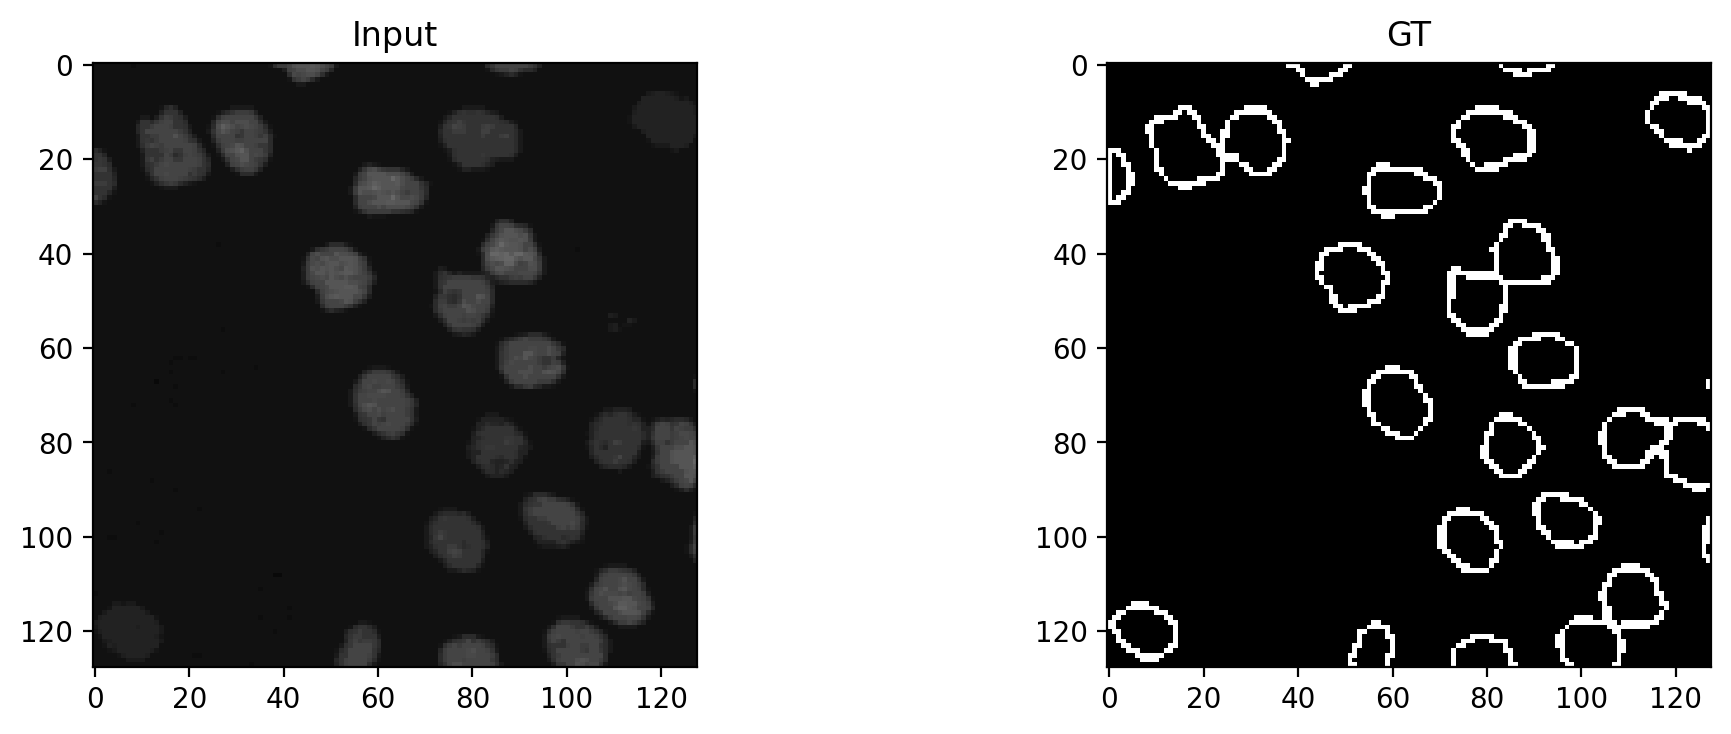

In [70]:
plt.figure(figsize=(12,4), dpi=200)
plt.subplot(1,2,1)
plt.title('Input')
plt.imshow(dataset[5000][0][0], cmap='gray', vmin=0, vmax=255)
plt.subplot(1,2,2)
plt.title('GT')
plt.imshow(dataset[5000][1][0], cmap='gray')

In [71]:
# imageS, labelS = [], []
# img_size = (128, 128)
# step = 30
# images = np.concatenate((np.array(folder_01), np.array(folder_02)), axis=0)
# labels = np.concatenate((np.array(folder_01_TRA_threshold), np.array(folder_02_TRA_threshold)), axis=0)
# for i in range(len(images)):
#     label=labels[i]
#     img=images[i]
#     for y in range(0, )
    
# dataset = np.concatenate(([imageS], [labelS])).transpose(1,0,2,3,4)

In [72]:
dataset.shape

(5049, 2, 1, 128, 128)

In [73]:
# compare_images_in_animation_cv([folder_01, global_grey_stretch(folder_01_TRA_threshold, False)], window_width=1900)

In [74]:
# compare_images_in_animation_cv([folder_01, global_grey_stretch(threshold_GT(folder_01, 20), False)], window_width=1900)

In [75]:
# compare_images_in_animation_cv([global_grey_stretch(threshold_GT(folder_01, 20), False), global_grey_stretch(folder_01_TRA_threshold, False)], window_width=1900)

In [7]:
# Network model
class NU_net_block(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=True)
                    )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=True)
                    )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class NU_net(nn.Module):
    def __init__(self, in_channels=1, n=16) -> None:
        super().__init__()
        self.concat = lambda fs: torch.cat(fs, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        ns = [n * 2 ** i for i in range(5)]

        self.to_00 = NU_net_block(in_channels, ns[0])
        self.to_10 = NU_net_block(ns[0], ns[1])
        self.to_20 = NU_net_block(ns[1], ns[2])
        self.to_30 = NU_net_block(ns[2], ns[3])
        self.to_40 = NU_net_block(ns[3], ns[4])

        self.to_01 = NU_net_block(ns[0] + ns[1], ns[0])
        self.to_11 = NU_net_block(ns[1] + ns[2], ns[1])
        self.to_21 = NU_net_block(ns[2] + ns[3], ns[2])
        self.to_31 = NU_net_block(ns[3] + ns[4], ns[3])

        self.to_02 = NU_net_block(ns[0] + ns[0] + ns[1], ns[0])
        self.to_12 = NU_net_block(ns[1] + ns[1] + ns[2], ns[1])
        self.to_22 = NU_net_block(ns[2] + ns[2] + ns[3], ns[2])

        self.to_03 = NU_net_block(ns[0] + ns[0] + ns[0] + ns[1], ns[0])
        self.to_13 = NU_net_block(ns[1] + ns[1] + ns[1] + ns[2], ns[1])

        self.to_04 = NU_net_block(ns[0] + ns[0] + ns[0] + ns[0] + ns[1], ns[0])

        self.final = nn.Conv2d(ns[0], 1, kernel_size=1)

    def forward(self, x):
        X00 = self.to_00(x)
        X10 = self.to_10(self.pool(X00))
        X20 = self.to_20(self.pool(X10))
        X30 = self.to_30(self.pool(X20))
        X40 = self.to_40(self.pool(X30))

        X01 = self.to_01(self.concat([X00, self.up(X10)]))
        X11 = self.to_11(self.concat([X10, self.up(X20)]))
        X21 = self.to_21(self.concat([X20, self.up(X30)]))
        X31 = self.to_31(self.concat([X30, self.up(X40)]))
        
        X02 = self.to_02(self.concat([X00, X01, self.up(X11)]))
        X12 = self.to_12(self.concat([X10, X11, self.up(X21)]))
        X22 = self.to_22(self.concat([X20, X21, self.up(X31)]))
        
        X03 = self.to_03(self.concat([X00, X01, X02, self.up(X12)]))
        X13 = self.to_13(self.concat([X10, X11, X12, self.up(X22)]))
        
        X04 = self.to_04(self.concat([X00, X01, X02, X03, self.up(X13)]))

        out = self.final(X04)

        return out





In [77]:
# loss function
class Dice_loss(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, pred, true):
        n = pred.size(0)
        p = torch.sigmoid(pred).view(n, -1)
        t = true.view(n, -1)

        dice = 2 * ((p * t).sum(1) + 1) / ((p + t).sum(1) + 1)

        return 1 - dice.mean()

In [78]:
# Dataset
class Custom_Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        img, img_GT = self.data[index]
        random_c = torch.rand(3)

        if random_c[0] > 0.5:
            img = VF.hflip(img)
            img_GT = VF.hflip(img_GT)

        if random_c[1] > 0.5:
            img = VF.vflip(img)
            img_GT = VF.vflip(img_GT)

        if img.shape[0] == img.shape[1]:

            if random_c[2] > 0.25:
                img = VF.rotate(img, 90)
                img_GT = VF.rotate(img_GT, 90)

            elif random_c[2] > 0.5:
                img = VF.rotate(img, 180)
                img_GT = VF.rotate(img_GT, 180)

            elif random_c[2] > 0.75:
                img = VF.rotate(img, 270)
                img_GT = VF.rotate(img_GT, 270)

        img = img / 255.0
        return (img.to(device), img_GT.to(device))

    def __len__(self):
        return len(self.data)

In [79]:
def eval_model(model,testloader):
    model.eval()
    total_loss = 0
    num = 0
    with torch.no_grad():
        for b in testloader:
            images, gts = b 
            preds = model(images) 
            num += len(images)
            total_loss += loss_fn(preds, gts).sum().item()

    print(f'Evaluate model on testset. Total loss: {total_loss}, Average loss: {total_loss / num}') 

In [80]:
# Perpare datasets
dataset_T = torch.Tensor(dataset)
dataset_len = len(dataset_T)
train_len = int(0.8 * dataset_len)
test_len = dataset_len - train_len
train_subset, test_subset = random_split(dataset_T, (train_len, test_len))
trainSet = Custom_Dataset(train_subset)
testSet = Custom_Dataset(test_subset)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testSet,batch_size=64, shuffle=False)

In [81]:
loss_fn = Dice_loss()
model = NU_net(1, 16).to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)
torch.cuda.empty_cache()

# training loop
optimiser.zero_grad()



In [93]:
epoch = 1000
model.train()
for e in range(epoch):
    tq = tqdm(trainloader)
    for b in tq:
        images, gts = b 
        preds = model(images)
        loss = loss_fn(preds, gts)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        tq.set_description(f'Epoch: {e + 1}/{epoch}, loss={loss.item()}')

    if (e+1) % 10 == 0:
        torch.save(model.state_dict(), '/content/drive/MyDrive/9517_gp/CheckPoint.pth')
        eval_model(model, testloader)
        model.train()

Epoch: 10/1000, loss=0.04147839546203613: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.5333828926086426, Average loss: 0.0015182008837709333


Epoch: 20/1000, loss=0.03826326131820679: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.0188127756118774, Average loss: 0.0010087255204077993


Epoch: 30/1000, loss=0.03861844539642334: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9953803420066833, Average loss: 0.0009855250910957261


Epoch: 40/1000, loss=0.03414720296859741: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.4819035530090332, Average loss: 0.001467231240603003


Epoch: 50/1000, loss=0.03789830207824707: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.269219696521759, Average loss: 0.0012566531648730288


Epoch: 60/1000, loss=0.03158074617385864: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.2463995814323425, Average loss: 0.0012340589915171708


Epoch: 70/1000, loss=0.031095147132873535: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9326455593109131, Average loss: 0.0009234114448622902


Epoch: 80/1000, loss=0.03300189971923828: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9674411416053772, Average loss: 0.0009578625164409675


Epoch: 90/1000, loss=0.029613614082336426: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.061437726020813, Average loss: 0.0010509284416047654


Epoch: 100/1000, loss=0.03296947479248047: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.0764842629432678, Average loss: 0.0010658260029141266


Epoch: 110/1000, loss=0.027783989906311035: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s]


Evaluate model on testset. Total loss: 0.943333625793457, Average loss: 0.0009339936889044129


Epoch: 120/1000, loss=0.029908478260040283: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9699583053588867, Average loss: 0.0009603547577810759


Epoch: 130/1000, loss=0.027812480926513672: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s]


Evaluate model on testset. Total loss: 1.0636066198349, Average loss: 0.0010530758612226731


Epoch: 140/1000, loss=0.025429844856262207: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9796690940856934, Average loss: 0.0009699694000848449


Epoch: 150/1000, loss=0.026371657848358154: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.928364634513855, Average loss: 0.0009191729054592624


Epoch: 160/1000, loss=0.02506077289581299: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.0828928351402283, Average loss: 0.0010721711239012161


Epoch: 170/1000, loss=0.028739750385284424: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9217296242713928, Average loss: 0.0009126035883875176


Epoch: 180/1000, loss=0.02692478895187378: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.1664469242095947, Average loss: 0.001154897944761975


Epoch: 190/1000, loss=0.024390995502471924: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.1635286808013916, Average loss: 0.0011520085948528629


Epoch: 200/1000, loss=0.024895548820495605: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.036562979221344, Average loss: 0.0010262999794270733


Epoch: 210/1000, loss=0.02659595012664795: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.8945852518081665, Average loss: 0.0008857279720872936


Epoch: 220/1000, loss=0.023900508880615234: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9692245721817017, Average loss: 0.0009596282892888135


Epoch: 230/1000, loss=0.030215561389923096: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.1444684267044067, Average loss: 0.001133137056142977


Epoch: 240/1000, loss=0.02449798583984375: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.8837805986404419, Average loss: 0.0008750302956836058


Epoch: 250/1000, loss=0.02283656597137451: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9253892302513123, Average loss: 0.0009162269606448636


Epoch: 260/1000, loss=0.02206367254257202: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.8997204303741455, Average loss: 0.0008908123073011341


Epoch: 270/1000, loss=0.025764286518096924: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9178683161735535, Average loss: 0.0009087805110629243


Epoch: 280/1000, loss=0.023672878742218018: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9517509341239929, Average loss: 0.0009423276575485078


Epoch: 290/1000, loss=0.020675182342529297: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.8880704641342163, Average loss: 0.0008792776872616003


Epoch: 300/1000, loss=0.02237069606781006: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.4207874536514282, Average loss: 0.001406720251140028


Epoch: 310/1000, loss=0.022670865058898926: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.8806588649749756, Average loss: 0.0008719394702722531


Epoch: 320/1000, loss=0.02411121129989624: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.957504391670227, Average loss: 0.0009480241501685417


Epoch: 330/1000, loss=0.02482318878173828: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.8887303471565247, Average loss: 0.0008799310367886382


Epoch: 340/1000, loss=0.019206464290618896: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.8727726340293884, Average loss: 0.0008641313208211767


Epoch: 350/1000, loss=0.022650837898254395: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9619007110595703, Average loss: 0.0009523769416431389


Epoch: 360/1000, loss=0.027383804321289062: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9012437462806702, Average loss: 0.0008923205408719507


Epoch: 370/1000, loss=0.022928595542907715: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.8733198046684265, Average loss: 0.0008646730739291352


Epoch: 380/1000, loss=0.01867997646331787: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.0305602550506592, Average loss: 0.0010203566881689695


Epoch: 390/1000, loss=0.019920289516448975: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.2484317421913147, Average loss: 0.0012360710318725888


Epoch: 400/1000, loss=0.019701600074768066: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8516278266906738, Average loss: 0.0008431958680105682


Epoch: 410/1000, loss=0.018934190273284912: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.1723085641860962, Average loss: 0.0011607015486991051


Epoch: 420/1000, loss=0.02029132843017578: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.9785760045051575, Average loss: 0.0009688871331734232


Epoch: 430/1000, loss=0.019256770610809326: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.8825846910476685, Average loss: 0.0008738462287600678


Epoch: 440/1000, loss=0.02130967378616333: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.2078248858451843, Average loss: 0.0011958662236090933


Epoch: 450/1000, loss=0.018977642059326172: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.8504562377929688, Average loss: 0.0008420358790029393


Epoch: 460/1000, loss=0.017686009407043457: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.3358722925186157, Average loss: 0.0013226458341768473


Epoch: 470/1000, loss=0.01877492666244507: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.8846184611320496, Average loss: 0.0008758598625069798


Epoch: 480/1000, loss=0.0179709792137146: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 1.1778174042701721, Average loss: 0.0011661558458120516


Epoch: 490/1000, loss=0.018867015838623047: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 0.8582853078842163, Average loss: 0.000849787433548729


Epoch: 500/1000, loss=0.015635669231414795: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8551074266433716, Average loss: 0.0008466410164785857


Epoch: 510/1000, loss=0.0173606276512146: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8757278919219971, Average loss: 0.0008670573187346506


Epoch: 520/1000, loss=0.01931554079055786: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 1.224928855895996, Average loss: 0.0012128008474217784


Epoch: 530/1000, loss=0.019274413585662842: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


Evaluate model on testset. Total loss: 1.1508906483650208, Average loss: 0.0011394956914505157


Epoch: 540/1000, loss=0.01573634147644043: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 1.0126248598098755, Average loss: 0.0010025988710988865


Epoch: 550/1000, loss=0.018391907215118408: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8818371295928955, Average loss: 0.0008731060689038569


Epoch: 560/1000, loss=0.017016351222991943: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 1.160699486732483, Average loss: 0.0011492074126064188


Epoch: 570/1000, loss=0.01566147804260254: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8759280443191528, Average loss: 0.0008672554894249038


Epoch: 580/1000, loss=0.0157889723777771: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8471314907073975, Average loss: 0.000838744050205344


Epoch: 590/1000, loss=0.017381787300109863: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8563153743743896, Average loss: 0.0008478370043310788


Epoch: 600/1000, loss=0.0162084698677063: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8801971077919006, Average loss: 0.0008714822849424759


Epoch: 610/1000, loss=0.014750421047210693: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8910831809043884, Average loss: 0.0008822605751528599


Epoch: 620/1000, loss=0.016634881496429443: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.890863299369812, Average loss: 0.0008820428706631802


Epoch: 630/1000, loss=0.01691800355911255: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8454954028129578, Average loss: 0.0008371241612009483


Epoch: 640/1000, loss=0.017934203147888184: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 1.1007976531982422, Average loss: 0.001089898666532913


Epoch: 650/1000, loss=0.01636338233947754: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.858439028263092, Average loss: 0.0008499396319436555


Epoch: 660/1000, loss=0.01487874984741211: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8543187379837036, Average loss: 0.0008458601366175283


Epoch: 670/1000, loss=0.018388986587524414: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8583099246025085, Average loss: 0.0008498118065371372


Epoch: 680/1000, loss=0.014586150646209717: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8316396474838257, Average loss: 0.0008234055915681442


Epoch: 690/1000, loss=0.017882704734802246: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8508469462394714, Average loss: 0.0008424227190489816


Epoch: 700/1000, loss=0.018388450145721436: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8172991275787354, Average loss: 0.0008092070570086488


Epoch: 710/1000, loss=0.014493882656097412: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8433160781860352, Average loss: 0.0008349664140455793


Epoch: 720/1000, loss=0.01632249355316162: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 1.1274614334106445, Average loss: 0.0011162984489214301


Epoch: 730/1000, loss=0.016485989093780518: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 1.086694598197937, Average loss: 0.0010759352457405317


Epoch: 740/1000, loss=0.014993488788604736: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8349429965019226, Average loss: 0.0008266762341603194


Epoch: 750/1000, loss=0.014324486255645752: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8336492776870728, Average loss: 0.0008253953244426463


Epoch: 760/1000, loss=0.015829801559448242: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 1.3284510970115662, Average loss: 0.0013152981158530358


Epoch: 770/1000, loss=0.01444089412689209: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.9354775547981262, Average loss: 0.000926215400790224


Epoch: 780/1000, loss=0.01463395357131958: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8570030331611633, Average loss: 0.0008485178546150132


Epoch: 790/1000, loss=0.01541590690612793: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 1.2287495732307434, Average loss: 0.001216583735872023


Epoch: 800/1000, loss=0.013389408588409424: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8931066393852234, Average loss: 0.0008842639993913103


Epoch: 810/1000, loss=0.015467822551727295: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8480009436607361, Average loss: 0.0008396048947136001


Epoch: 820/1000, loss=0.014334499835968018: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.8271973729133606, Average loss: 0.0008190072999142184


Epoch: 830/1000, loss=0.015850841999053955: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.9646593332290649, Average loss: 0.0009551082507218465


Epoch: 840/1000, loss=0.014893889427185059: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 1.2121521830558777, Average loss: 0.0012001506762929482


Epoch: 850/1000, loss=0.012741446495056152: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.810447096824646, Average loss: 0.0008024228681432139


Epoch: 860/1000, loss=0.013588547706604004: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 1.2231812477111816, Average loss: 0.0012110705422882988


Epoch: 870/1000, loss=0.015189945697784424: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 1.1202677488327026, Average loss: 0.00110917598894327


Epoch: 880/1000, loss=0.013802051544189453: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


Evaluate model on testset. Total loss: 0.9283108711242676, Average loss: 0.000919119674380463


Epoch: 890/1000, loss=0.013608574867248535: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


Evaluate model on testset. Total loss: 0.8362904191017151, Average loss: 0.0008280103159422922


Epoch: 900/1000, loss=0.012841463088989258: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


Evaluate model on testset. Total loss: 0.8206276297569275, Average loss: 0.0008125026037197302


Epoch: 910/1000, loss=0.013737201690673828: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


Evaluate model on testset. Total loss: 1.2207911014556885, Average loss: 0.0012087040608472163


Epoch: 920/1000, loss=0.013207733631134033: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


Evaluate model on testset. Total loss: 0.8523162007331848, Average loss: 0.0008438774264684998


Epoch: 930/1000, loss=0.01343381404876709: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


Evaluate model on testset. Total loss: 0.864203155040741, Average loss: 0.0008556466881591495


Epoch: 940/1000, loss=0.011694908142089844: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


Evaluate model on testset. Total loss: 0.8084930777549744, Average loss: 0.0008004881957970043


Epoch: 950/1000, loss=0.014418303966522217: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


Evaluate model on testset. Total loss: 0.8686490654945374, Average loss: 0.0008600485796975617


Epoch: 960/1000, loss=0.01359933614730835: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


Evaluate model on testset. Total loss: 0.8757114410400391, Average loss: 0.000867041030732712


Epoch: 970/1000, loss=0.015217006206512451: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


Evaluate model on testset. Total loss: 1.1086565256118774, Average loss: 0.0010976797283285915


Epoch: 980/1000, loss=0.012257695198059082: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


Evaluate model on testset. Total loss: 0.9494960308074951, Average loss: 0.0009400950800074209


Epoch: 990/1000, loss=0.012585282325744629: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


Evaluate model on testset. Total loss: 1.1729947924613953, Average loss: 0.0011613809826350448


Epoch: 1000/1000, loss=0.013877153396606445: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


Evaluate model on testset. Total loss: 0.8627012968063354, Average loss: 0.000854159699808253


In [130]:
model = NU_net(1, 16).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/9517_gp/CheckPoint.pth'))

<All keys matched successfully>

In [83]:
model.eval()
model.to(device)

NU_net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (to_00): NU_net_block(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (to_10): NU_net_block(
    (conv1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Batc

In [ ]:
testSet[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'))

In [ ]:
inputs = None
preds = None
gts = None
with torch.no_grad():
    for b in testloader:
        images, gts = b 
        print(images)
        inputs = images.clone()
        preds = model(images)
        break
    

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0353],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

In [71]:
def image_processing_with_model(img, model, step=64, size=128, padding=5):
    img = cv2.resize(img, (0, 0), fx=.5, fy=.5)
    img = img / 255
    out_img = np.zeros_like(img).astype(np.uint8)
    img_list = []
    positions = []
    h, w = img.shape
    for y in range((h - size) // step):
        for x in range((w - size) // step):
            sub = img[y*step:y*step+size, x*step:x*step+size]
            img_list.append([sub])
            positions.append((x*step, y*step))
        sub = img[y*step:y*step+size, -size-1:-1]
        img_list.append([sub])
        positions.append((-size-1, y*step))

    for x in range((w - size) // step):
        sub = img[-size-1:-1, x*step:x*step+size]
        img_list.append([sub])
        positions.append((x*step, -size-1))
    sub = img[-size-1:-1, -size-1:-1]
    img_list.append([sub])
    positions.append((-size-1, -size-1))
    # print(positions)
    
    inputs = torch.Tensor(np.array(img_list)).cpu().cuda()
    outputs = model(inputs).cpu().detach().numpy()

    for i in range(len(positions)):
        x, y = positions[i]
        padding_x, padding_y = 0, 0
        # blackb = np.zeros_like(out_img)

        if x > 0: padding_x = padding
        if y > 0: padding_y = padding
        # blackb[y+padding_y:y+size, x+padding_x:x+size]\
        #  = np.where(outputs[i][0]>0, 255, 0)[padding_y:, padding_x:]
        # out_img = cv2.bitwise_or(out_img, blackb)

        out_img[y+padding_y:y+size, x+padding_x:x+size]\
         = np.where(outputs[i][0]>0, 255, 0)[padding_y:, padding_x:]

    return out_img

In [51]:
def folder_processing_with_model(image_folder, model, step=64, size=128):
    out = []
    for img in image_folder:
        out.append(image_processing_with_model(img, model, step, size))
    return out

In [8]:
model = NU_net(1, 16)
model.load_state_dict(torch.load('/content/drive/MyDrive/9517_gp/CheckPoint.pth'))
model.eval()

NU_net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (to_00): NU_net_block(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (to_10): NU_net_block(
    (conv1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Batc

In [9]:
model.eval()
model.cuda()


NU_net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (to_00): NU_net_block(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (to_10): NU_net_block(
    (conv1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Batc

In [16]:
folder_03_original = open_files('03')
folder_04_original = open_files('04')
folder_03 = global_grey_stretch(folder_03_original)
folder_04 = global_grey_stretch(folder_04_original)

In [72]:
folder_03_output = folder_processing_with_model(folder_03, model)

In [18]:
folder_03_output = np.where(np.array(folder_03_output)>0, 255, 0)

In [73]:
i=75

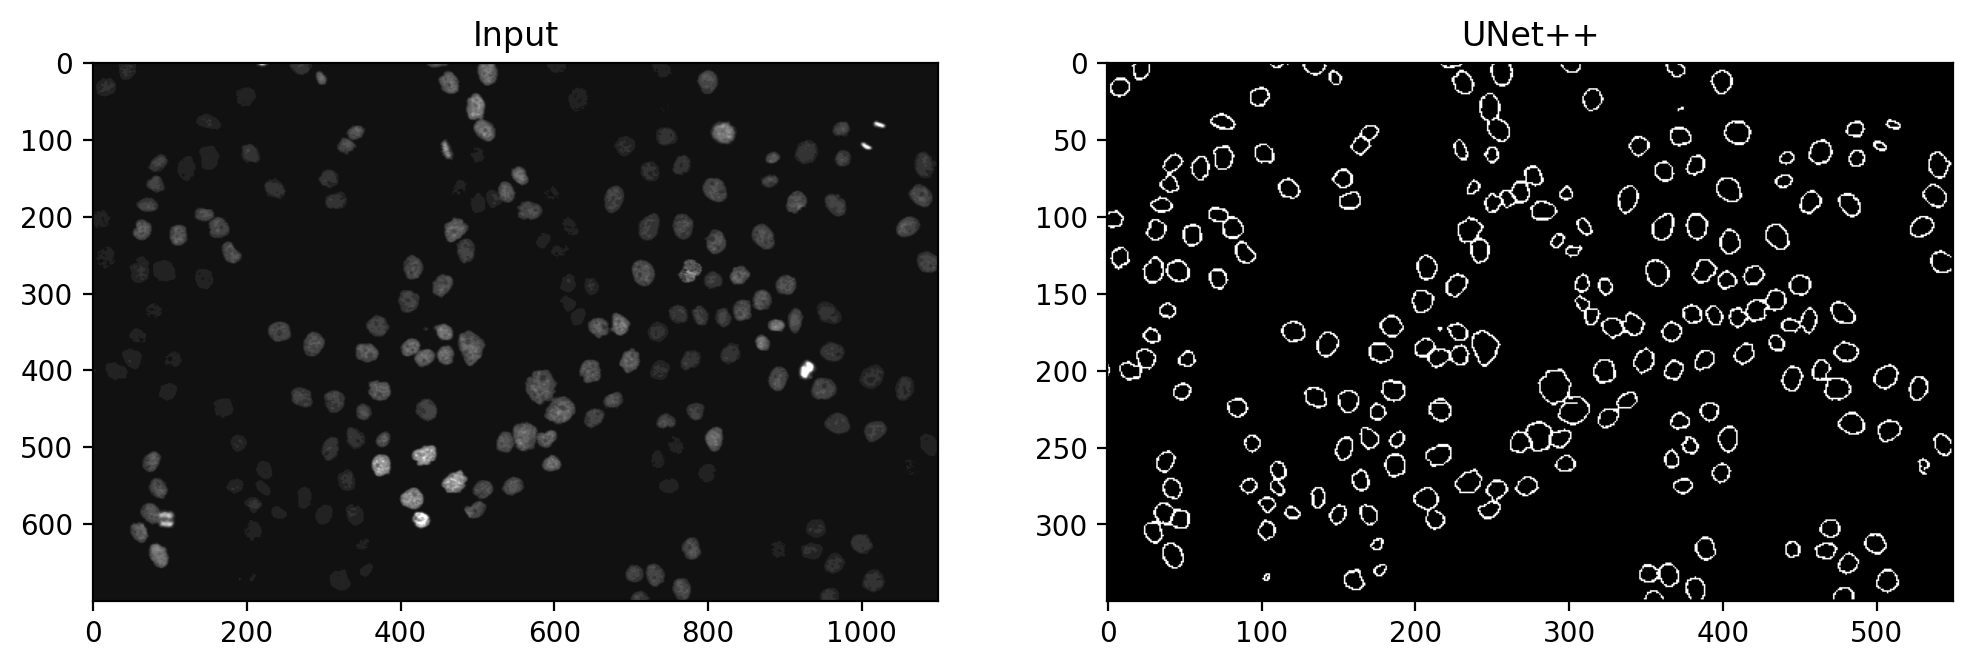

In [76]:
a = folder_03[i]
b = folder_03_output[i]
i += 1
plt.figure(figsize=(12,4), dpi=200)
plt.subplot(1,2,1)
plt.title('Input')
plt.imshow(a, cmap='gray')
plt.subplot(1,2,2)
plt.title('UNet++')
plt.imshow(b, cmap='gray')

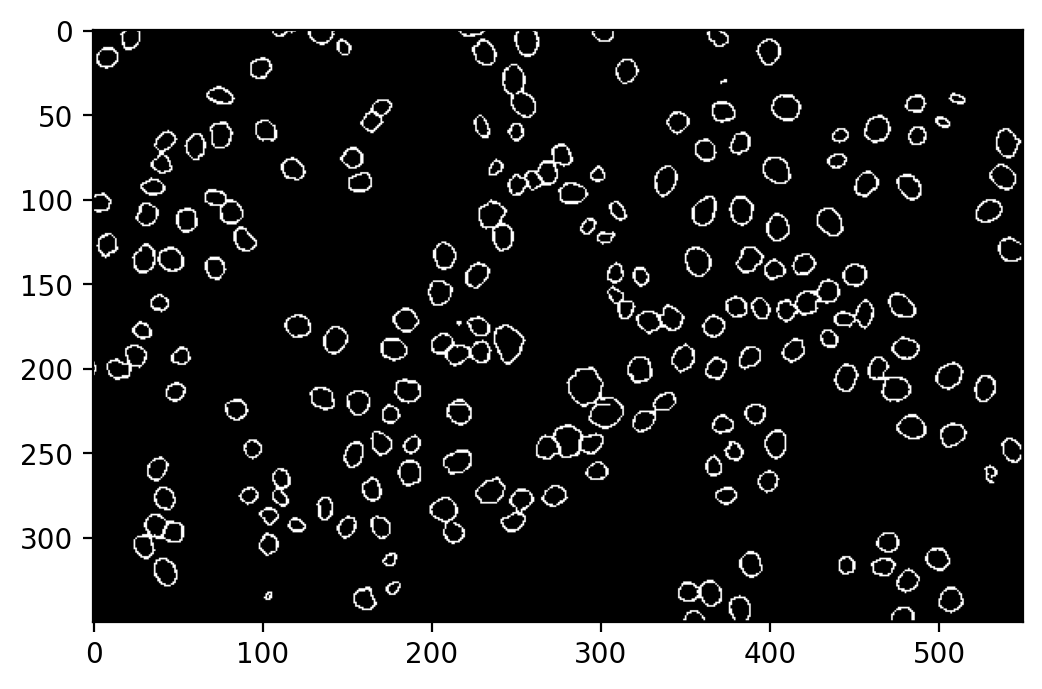

In [77]:

plt.figure(dpi=200)
plt.imshow(b, cmap='gray')